In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

import os
import numpy as np
import matplotlib.pyplot as plt

# File Loading and Function Definitions

In [2]:
# I'm running this locally, change to /tigress/jialiu/zack/ if you're on tigress
data_dir = '/home/zequnl/Projects/neutrino_mpk/'
PS_directory = data_dir + 'powerspectrum'
PC_directory = data_dir + 'peakcounts'

# this code finds all the filenames and puts them in a list,
# BUT ONLY FOR z05, we'll load in the rest separately 
PS_names, PC_names = [], []
for filename in os.listdir(PS_directory):
    if filename.endswith("_z05.npy"):  
        PS_names.append(filename)
for filename in os.listdir(PC_directory):
    if filename.endswith("_z05.npy"): 
        PC_names.append(filename)
print('Found', len(PS_names), 'PS files and', len(PC_names), 'PC files.')

def get_As( string_with_As ):
    return float(string_with_As.split('_As')[1].split('_mva')[0])

def get_filenames_PS_PC( input_As ):
    PS_filename_candidates = [x for x in PS_names if np.isclose(input_As,get_As(x), atol=1e-4)]
    PC_filename_candidates = [x for x in PC_names if np.isclose(input_As,get_As(x), atol=1e-4)]
    if len(PS_filename_candidates) == 1 and len(PC_filename_candidates) == 1:
        return PS_filename_candidates[0], PC_filename_candidates[0]
    else:
        print("multiple file candidates found! possibly fiducial model 1a/1b")
        return None
from astropy.table import Table
t = Table.read(data_dir + 'cosmological_parameters.txt', format='ascii')

PS_filename_list_temp = []
PC_filename_list_temp = []
for row in t:
    # special cases (fiducial 1 and 2)
    if '1a(fiducial)' in row['Model']:
        PS_name = 'Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50_z05.npy'
        PC_name = 'Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S_z05.npy'
    elif '1b(fiducial)' in row['Model']:
        PS_name = 'Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PS_50_z05.npy'
        PC_name = 'Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PC_S_z05.npy'
    else:
        PS_name, PC_name = get_filenames_PS_PC(row['10^9*A_s'])
    
    PS_filename_list_temp.append(PS_name)
    PC_filename_list_temp.append(PC_name)

# put the filenames in the table for easy access
t['PS'] = np.array(PS_filename_list_temp)
t['PC'] = np.array(PC_filename_list_temp)

# show the table
t

Found 101 PS files and 101 PC files.


Model,M_nu(eV),Omega_m,10^9*A_s,sigma_8(derived),PS,PC
str12,float64,float64,float64,float64,str86,str85
1a(fiducial),0.0,0.3,2.1,0.8523,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50_z05.npy,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S_z05.npy
1b(fiducial),0.1,0.3,2.1,0.8295,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PS_50_z05.npy,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PC_S_z05.npy
2,0.06271,0.3815,2.2004,1.0135,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PS_50_z05.npy,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PC_S_z05.npy
3,0.06522,0.2821,1.8826,0.7563,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PS_50_z05.npy,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PC_S_z05.npy
4,0.06773,0.4159,1.6231,0.9171,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PS_50_z05.npy,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PC_S_z05.npy
5,0.07024,0.2023,2.3075,0.6231,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PS_50_z05.npy,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PC_S_z05.npy
6,0.07275,0.3283,2.2883,0.9324,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PS_50_z05.npy,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PC_S_z05.npy
7,0.07526,0.3355,1.5659,0.7828,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PS_50_z05.npy,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PC_S_z05.npy
8,0.07778,0.2597,2.4333,0.8008,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PS_50_z05.npy,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PC_S_z05.npy


# Code Structure
I'm using a *singleton* code format here, because it will take the least amount of time and is perhaps well-suited to a jupyter notebook. This means the loaded in data are global, and running the `set_data()` function changes these global variables.

In [3]:
from forecast import buildInterpolator

def set_data(redshifts=['05', '10', '15', '20'], l_min=200, l_max=5000):
#     cutoff_initial_PS = 5
    kappa_min = -9.61769831e-03
    
    global PS_means
    global PC_means
    global ell
    global kappa
    
    global obsarr_PS, params_PS, interp_PS, invcov_PS 
    global obsarr_PC, params_PC, interp_PC, invcov_PC 
    
    PS_means = []
    PC_means = []
    
    PC_redshifts = [rr for rr in redshifts if not rr=='11000' ]
    
    for row in t:
        PS_filenames = [ row['PS'].replace('05.npy', r+'.npy') \
                        for r in redshifts ]
        PC_filenames = [ row['PC'].replace('05.npy', r+'.npy') \
                        for r in PC_redshifts ]
        PS_arr = [ np.load( PS_directory + r'/' + filename )[:,:] 
                  for filename in PS_filenames ]
        PC_arr = [ np.load( PC_directory + r'/' + filename )[:,:] 
                  for filename in PC_filenames ]

        # now stack them together sideways
        PS_arr = np.hstack(PS_arr)
        PC_arr = np.hstack(PC_arr)

        # filter out ell ranges
        ell = PS_arr[0,:]
        ell_filter = np.logical_and( ell > l_min, ell < l_max )

        PS_arr = ((PS_arr.T)[ell_filter]).T
    #     PC_arr = ((PC_arr.T)[ell_filter]).T

        # first row of PS_arr is ell
        ell = PS_arr[0,:]
        PS_realizations = PS_arr[1:,:]

        # first and second row of PC are kappa, SNR
        kappa = PC_arr[0,:]
        PC_arr = ((PC_arr.T)[kappa > kappa_min]).T

        kappa = PC_arr[0,:]
        SNR = PC_arr[1,:]
        PC_realizations = PC_arr[2:,:]

        if row['Model'] == '1a(fiducial)':
            print('shapes,',PS_realizations.shape, PC_realizations.shape)
            PS_cov = np.cov(PS_realizations.T)
            PC_cov = np.cov(PC_realizations.T)

        PS_means.append( np.mean(PS_realizations, axis=0) )
        PC_means.append( np.mean(PC_realizations, axis=0) )

    obsarr_PS = np.array( PS_means ) 
    params_PS = np.array( [t['M_nu(eV)'], t['Omega_m'], t['10^9*A_s']] ).T
    interp_PS = buildInterpolator(obsarr_PS, params_PS)
    
    nrealizations, nbins = PS_realizations.shape
    correction = (nrealizations - nbins - 2) / (nrealizations - 1)
    invcov_PS = correction * np.linalg.inv(PS_cov * 12.25/2e4) 
    print('n', nrealizations, 'p', nbins, 'multiplier',correction)
    
    obsarr_PC = np.array( PC_means ) 
    params_PC = np.array( [t['M_nu(eV)'], t['Omega_m'], t['10^9*A_s']] ).T
    interp_PC = buildInterpolator(obsarr_PC, params_PC)
    
    nrealizations, nbins = PC_realizations.shape
    correction = (nrealizations - nbins - 2) / (nrealizations - 1)
    invcov_PC = correction * np.linalg.inv(PC_cov * 12.25/2e4)
    print('n', nrealizations, 'p', nbins, 'multiplier',correction)


In [4]:

def P( mu, obsarr, mu_length, interp, invcov ):
    mu = interp( mu )
    mu = np.array(list(mu.tolist())).reshape( mu_length ) 
    d = obsarr[1]
    dm = d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(invcov,dm)) )


shapes, (1000, 24) (1000, 143)
n 1000 p 24 multiplier 0.974974974974975
n 1000 p 143 multiplier 0.8558558558558559


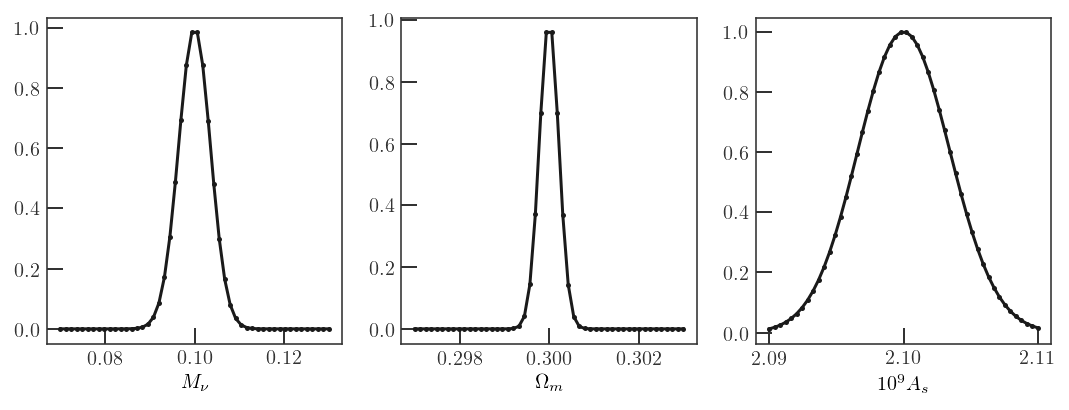

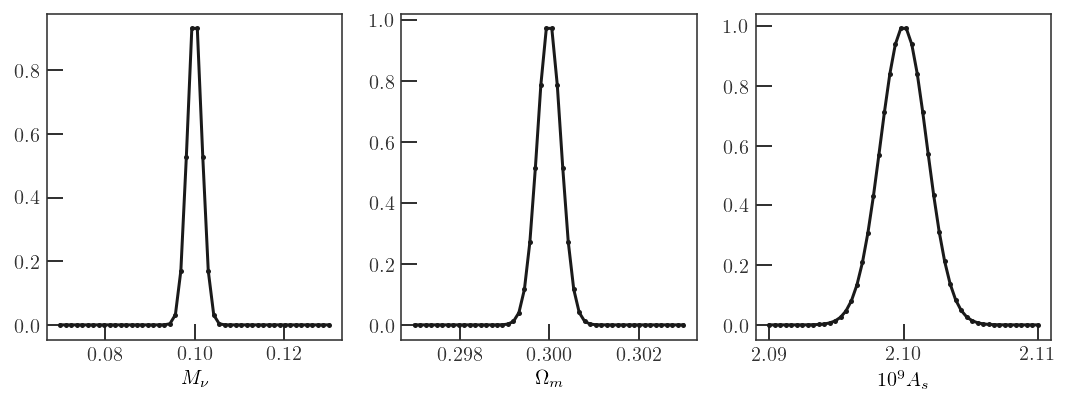

In [5]:
from forecast import findlevel
import matplotlib.cm as cm
set_data(redshifts=['10']) 

u = np.linspace(0.1 - 0.03, 0.1 + 0.03, 50)
v = np.linspace(0.3 - 0.003, 0.3 + 0.003, 50)
w = np.linspace(2.1 - 0.01, 2.1 + 0.01, 50)

fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].plot( u, [P( (p, 0.3, 2.1), obsarr_PS, len(ell), interp_PS, invcov_PS ) for p in u] )
ax[0].set_xlabel(r'$M_{\nu}$')
ax[1].plot( v, [P( (0.1, p, 2.1), obsarr_PS, len(ell), interp_PS, invcov_PS ) for p in v] )
ax[1].set_xlabel(r'$\Omega_m$')
ax[2].plot( w, [P( (0.1, 0.3, p), obsarr_PS, len(ell), interp_PS, invcov_PS ) for p in w] )
ax[2].set_xlabel(r'$10^9A_s$')

fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].plot( u, [P( (p, 0.3, 2.1), obsarr_PC, len(kappa), interp_PC, invcov_PC ) for p in u] )
ax[0].set_xlabel(r'$M_{\nu}$')
ax[1].plot( v, [P( (0.1, p, 2.1), obsarr_PC, len(kappa), interp_PC, invcov_PC ) for p in v] )
ax[1].set_xlabel(r'$\Omega_m$')
ax[2].plot( w, [P( (0.1, 0.3, p), obsarr_PC, len(kappa), interp_PC, invcov_PC ) for p in w] )
ax[2].set_xlabel(r'$10^9A_s$')

In [65]:
nres = 50

# Comparing Different Scenarios

shapes, (1000, 24) (1000, 143)
n 1000 p 24 multiplier 0.974974974974975
n 1000 p 143 multiplier 0.8558558558558559


KeyboardInterrupt: 

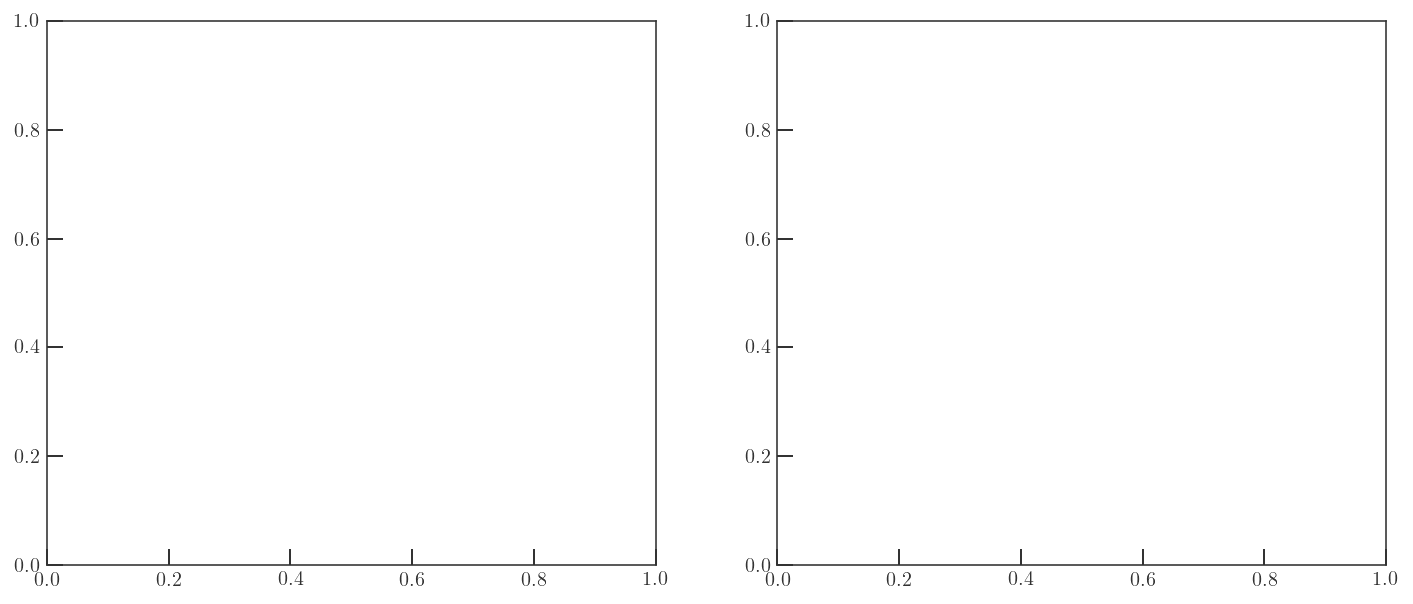

In [88]:
# SCENARIO 1:  z=1 only (this is the mean redshift for LSST)
set_data(redshifts=['10']) 

fig, ax = plt.subplots(1,2, figsize=(12,5))

u = np.linspace(0.1 - 0.03*3, 0.1 + 0.03*3, nres)
v = np.linspace(0.3 - 0.003*3, 0.3 + 0.003*3, nres)
w = np.linspace(2.1 - 0.01*3, 2.1 + 0.01*3, nres)

X, Y, Z = np.meshgrid(u, v, w)
PS_cube = [P( (x,y,z), obsarr_PS, len(ell), interp_PS, invcov_PS ) for \
           x,y,z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))]
PS_cube = np.array(PS_cube)
PS_cube = PS_cube.reshape(X.shape)

u = np.linspace(0.1 - 0.03, 0.1 + 0.03, nres)
v = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres)
w = np.linspace(2.1 - 0.01, 2.1 + 0.01, nres)
X, Y, Z = np.meshgrid(u, v, w)

PC_cube = [P( (x,y,z), obsarr_PC, len(kappa), interp_PC, invcov_PC ) for \
           x,y,z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))]
PC_cube = np.array(PC_cube)
PC_cube = PC_cube.reshape(X.shape)

PS_cube1 = PS_cube
PC_cube1 = PC_cube

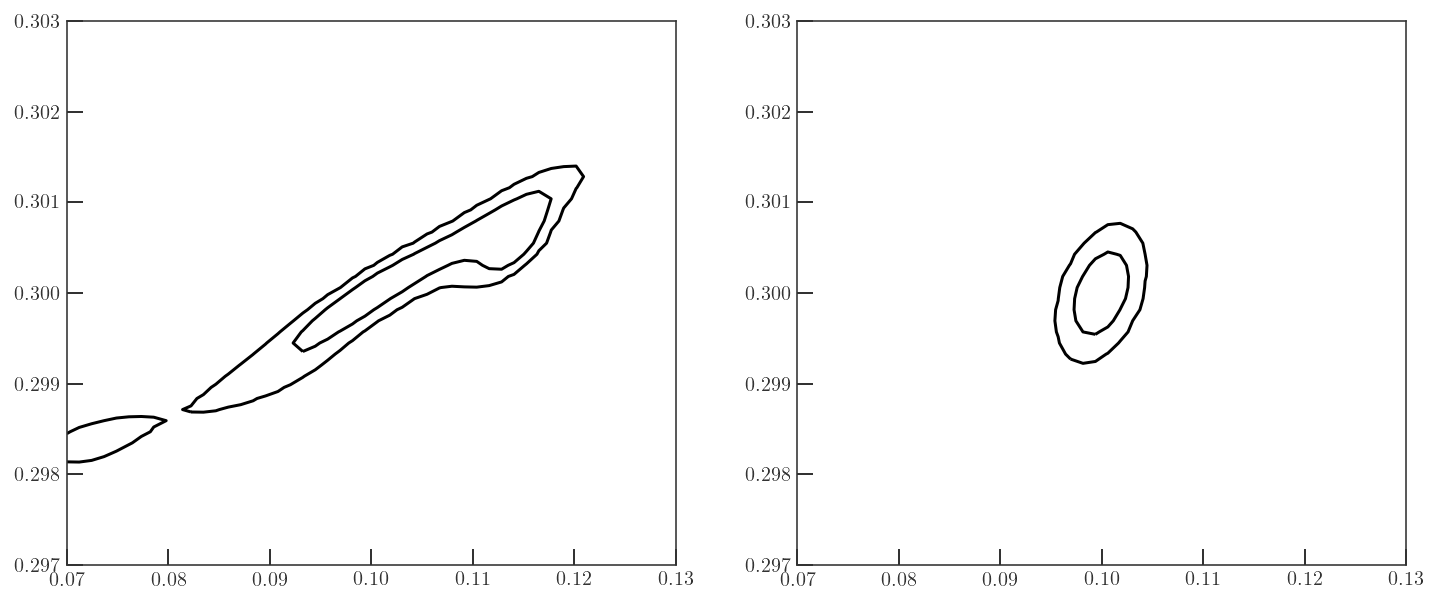

In [72]:
PS_flat = np.sum(PS_cube1, axis=2)
PC_flat = np.sum(PC_cube1, axis=2)

fig, ax = plt.subplots(1,2,figsize=(12,5))

c_68, c_95, c_99 = findlevel(PS_flat)
ax[0].contour( U, V, PS_flat, levels=[c_95, c_68], \
                     colors=('black'))
ax[0].plot([],[], '-', label='z=1', color='black')

c_68, c_95, c_99 = findlevel(PC_flat)
ax[1].contour( U, V, PC_flat, levels=[c_95, c_68], \
                     colors=('black'))
ax[1].plot([],[], '-', label='z=1', color='black')

In [73]:
# SCENARIO 2. galaxy tomography of 4 bins: z=0.5, 1, 1.5, 2
set_data(redshifts=['05', '10', '15', '20']) 


# fig, ax = plt.subplots(1,2)

u = np.linspace(0.1 - 0.03, 0.1 + 0.03, nres)
v = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres)
w = np.linspace(2.1 - 0.01, 2.1 + 0.01, nres)

X, Y, Z = np.meshgrid(u, v, w)
PS_cube = [P( (x,y,z), obsarr_PS, len(ell), interp_PS, invcov_PS ) for \
           x,y,z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))]
PS_cube = np.array(PS_cube)
PS_cube = PS_cube.reshape(X.shape)


X, Y, Z = np.meshgrid(u, v, w)

PC_cube = [P( (x,y,z), obsarr_PC, len(kappa), interp_PC, invcov_PC ) for \
           x,y,z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))]
PC_cube = np.array(PC_cube)
PC_cube = PC_cube.reshape(X.shape)

PS_cube2 = PS_cube
PC_cube2 = PC_cube

shapes, (1000, 96) (1000, 575)
n 1000 p 96 multiplier 0.9029029029029029
n 1000 p 575 multiplier 0.42342342342342343


In [74]:
# Scenario 3. galaxy+CMB: z=1 and z=1100
set_data(redshifts=['10', '11000']) 


# fig, ax = plt.subplots(1,2)

u = np.linspace(0.1 - 0.03*2, 0.1 + 0.03*2, nres)
v = np.linspace(0.3 - 0.003*2, 0.3 + 0.003*2, nres)
w = np.linspace(2.1 - 0.01*2, 2.1 + 0.01*2, nres)

X, Y, Z = np.meshgrid(u, v, w)
PS_cube = [P( (x,y,z), obsarr_PS, len(ell), interp_PS, invcov_PS ) for \
           x,y,z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))]
PS_cube = np.array(PS_cube)
PS_cube = PS_cube.reshape(X.shape)

X, Y, Z = np.meshgrid(u, v, w)

PC_cube = [P( (x,y,z), obsarr_PC, len(kappa), interp_PC, invcov_PC ) for \
           x,y,z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))]
PC_cube = np.array(PC_cube)
PC_cube = PC_cube.reshape(X.shape)

PS_cube3 = PS_cube
PC_cube3 = PC_cube

shapes, (1000, 48) (1000, 143)
n 1000 p 48 multiplier 0.950950950950951
n 1000 p 143 multiplier 0.8558558558558559


In [75]:
# Scenario 4. redshifts + CMB = z=0.5, 1, 1.5, 2, 1100
set_data(redshifts=['05', '10', '15', '20', '11000']) 

# fig, ax = plt.subplots(1,2)

u = np.linspace(0.1 - 0.03, 0.1 + 0.03, nres)
v = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres)
w = np.linspace(2.1 - 0.01, 2.1 + 0.01, nres)

X, Y, Z = np.meshgrid(u, v, w)
PS_cube = [P( (x,y,z), obsarr_PS, len(ell), interp_PS, invcov_PS ) for \
           x,y,z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))]
PS_cube = np.array(PS_cube)
PS_cube = PS_cube.reshape(X.shape)


X, Y, Z = np.meshgrid(u, v, w)

PC_cube = [P( (x,y,z), obsarr_PC, len(kappa), interp_PC, invcov_PC ) for \
           x,y,z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))]
PC_cube = np.array(PC_cube)
PC_cube = PC_cube.reshape(X.shape)

PS_cube4 = PS_cube
PC_cube4 = PC_cube

shapes, (1000, 120) (1000, 575)
n 1000 p 120 multiplier 0.8788788788788788
n 1000 p 575 multiplier 0.42342342342342343


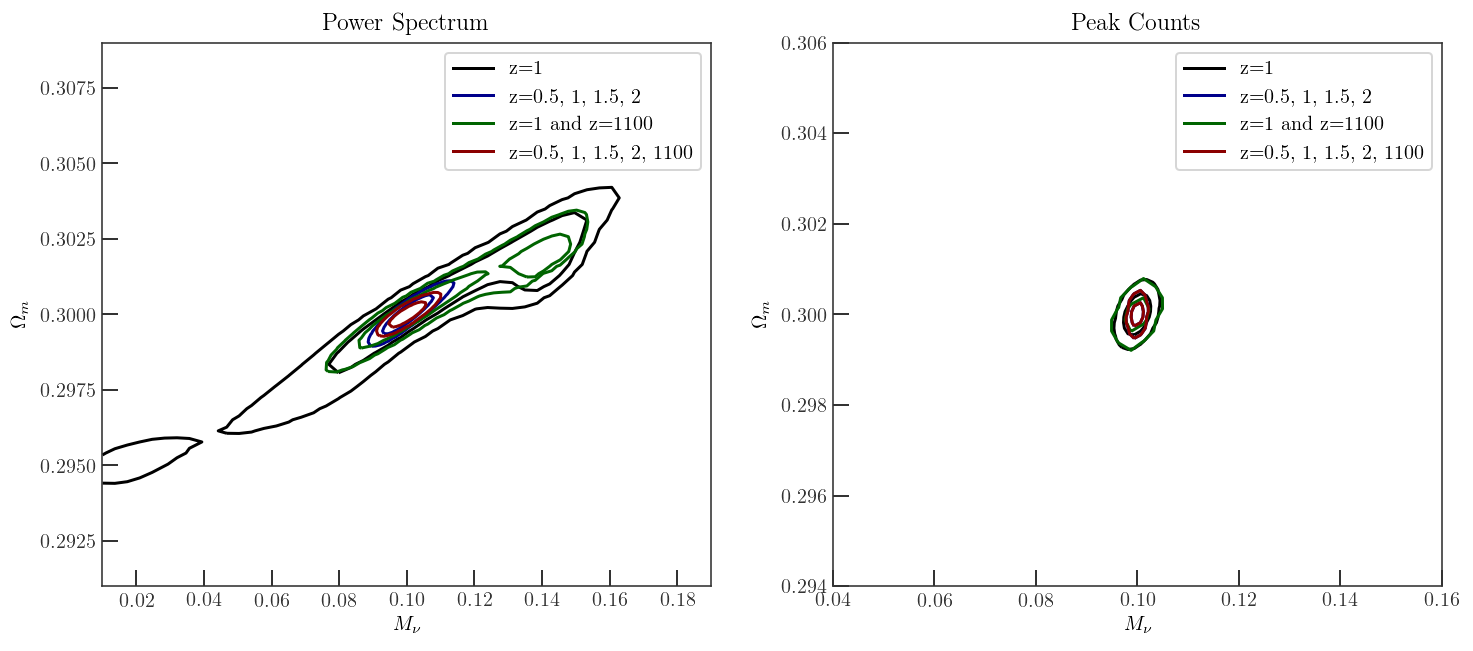

In [89]:
# scenario 1
u = np.linspace(0.1 - 0.03*3, 0.1 + 0.03*3, nres)
v = np.linspace(0.3 - 0.003*3, 0.3 + 0.003*3, nres)
U, V = np.meshgrid(u, v)

PS_flat = np.sum(PS_cube1, axis=2)
PC_flat = np.sum(PC_cube1, axis=2)

fig, ax = plt.subplots(1,2,figsize=(12,5))

c_68, c_95, c_99 = findlevel(PS_flat)
ax[0].contour( U, V, PS_flat, levels=[c_95, c_68], \
                     colors=('black'))
ax[0].plot([],[], '-', label='z=1', color='black')



u = np.linspace(0.1 - 0.03, 0.1 + 0.03, nres)
v = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres)
U, V = np.meshgrid(u, v)

c_68, c_95, c_99 = findlevel(PC_flat)
ax[1].contour( U, V, PC_flat, levels=[c_95, c_68], \
                     colors=('black'))
ax[1].plot([],[], '-', label='z=1', color='black')

# scenario 2
u = np.linspace(0.1 - 0.03, 0.1 + 0.03, nres)
v = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres)
U, V = np.meshgrid(u, v)

PS_flat = np.sum(PS_cube2, axis=2)
PC_flat = np.sum(PC_cube2, axis=2)

# fig, ax = plt.subplots(1,2,figsize=(12,5))

c_68, c_95, c_99 = findlevel(PS_flat)
ax[0].contour( U, V, PS_flat, levels=[c_95, c_68], \
                     colors=('darkblue'))
ax[0].plot([],[], '-', label='z=0.5, 1, 1.5, 2', color='darkblue')

c_68, c_95, c_99 = findlevel(PC_flat)
ax[1].contour( U, V, PC_flat, levels=[c_95, c_68], \
                     colors=('darkblue'))
ax[1].plot([],[], '-', label='z=0.5, 1, 1.5, 2', color='darkblue')


# scenario 3
PS_flat = np.sum(PS_cube3, axis=2)
PC_flat = np.sum(PC_cube3, axis=2)

# fig, ax = plt.subplots(1,2,figsize=(12,5))


u = np.linspace(0.1 - 0.03*2, 0.1 + 0.03*2, nres)
v = np.linspace(0.3 - 0.003*2, 0.3 + 0.003*2, nres)
U, V = np.meshgrid(u, v)

c_68, c_95, c_99 = findlevel(PS_flat)
ax[0].contour( U, V, PS_flat, levels=[c_95, c_68], \
                     colors=('darkgreen'))
ax[0].plot([],[], '-', label='z=1 and z=1100', color='darkgreen')

c_68, c_95, c_99 = findlevel(PC_flat)
ax[1].contour( U, V, PC_flat, levels=[c_95, c_68], \
                     colors=('darkgreen'))
ax[1].plot([],[], '-', label='z=1 and z=1100', color='darkgreen')

# scenario 4
PS_flat = np.sum(PS_cube4, axis=2)
PC_flat = np.sum(PC_cube4, axis=2)

# fig, ax = plt.subplots(1,2,figsize=(12,5))

u = np.linspace(0.1 - 0.03, 0.1 + 0.03, nres)
v = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres)
U, V = np.meshgrid(u, v)

c_68, c_95, c_99 = findlevel(PS_flat)
ax[0].contour( U, V, PS_flat, levels=[c_95, c_68], \
                     colors=('darkred'))
ax[0].plot([],[], '-', label='z=0.5, 1, 1.5, 2, 1100', color='darkred')

c_68, c_95, c_99 = findlevel(PC_flat)
ax[1].contour( U, V, PC_flat, levels=[c_95, c_68], \
                     colors=('darkred'))
ax[1].plot([],[], '-', label='z=0.5, 1, 1.5, 2, 1100', color='darkred')

ax[0].legend()
ax[1].legend()

ax[0].set_title('Power Spectrum')
ax[1].set_title('Peak Counts')

ax[0].set_xlabel(r'$M_{\nu}$')
ax[0].set_ylabel(r'$\Omega_m$')
ax[1].set_xlabel(r'$M_{\nu}$')
ax[1].set_ylabel(r'$\Omega_m$')

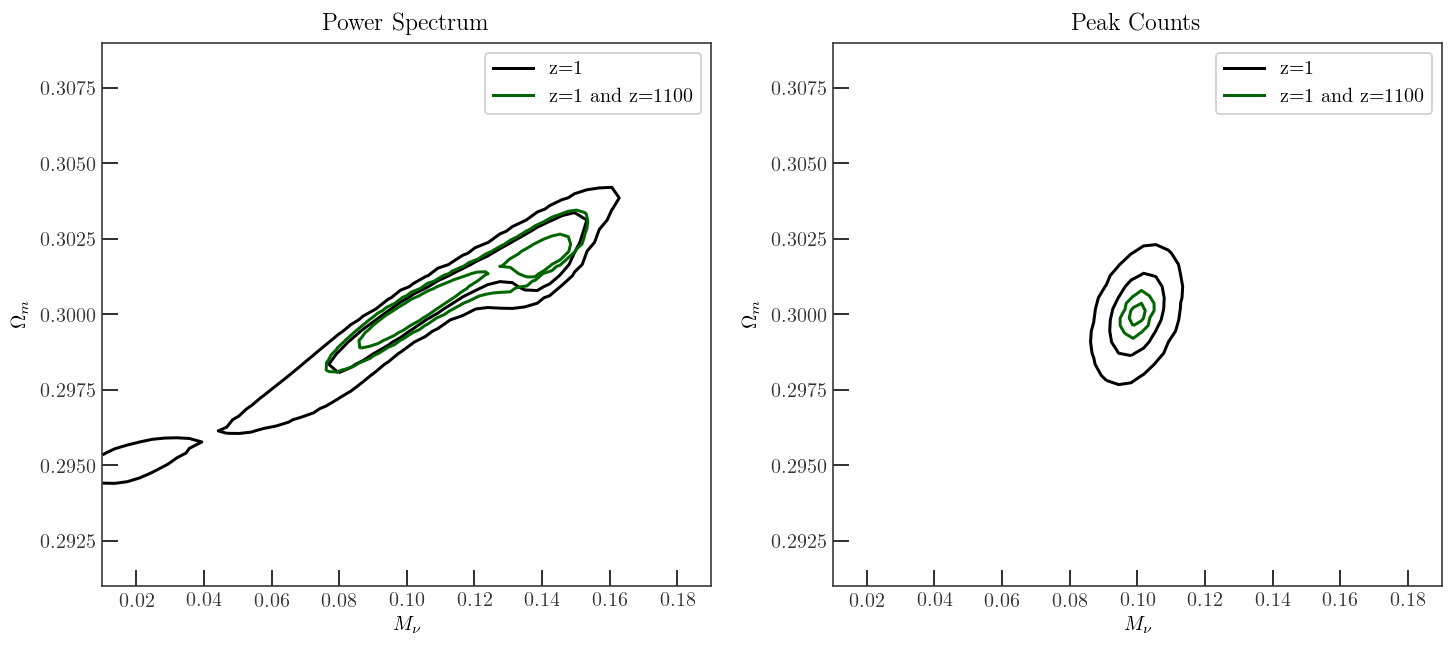

In [87]:
# scenario 1
u = np.linspace(0.1 - 0.03*3, 0.1 + 0.03*3, nres)
v = np.linspace(0.3 - 0.003*3, 0.3 + 0.003*3, nres)
U, V = np.meshgrid(u, v)

PS_flat = np.sum(PS_cube1, axis=2)
PC_flat = np.sum(PC_cube1, axis=2)

fig, ax = plt.subplots(1,2,figsize=(12,5))

c_68, c_95, c_99 = findlevel(PS_flat)
ax[0].contour( U, V, PS_flat, levels=[c_95, c_68], \
                     colors=('black'))
ax[0].plot([],[], '-', label='z=1', color='black')

c_68, c_95, c_99 = findlevel(PC_flat)
ax[1].contour( U, V, PC_flat, levels=[c_95, c_68], \
                     colors=('black'))
ax[1].plot([],[], '-', label='z=1', color='black')



# scenario 3
PS_flat = np.sum(PS_cube3, axis=2)
PC_flat = np.sum(PC_cube3, axis=2)

# fig, ax = plt.subplots(1,2,figsize=(12,5))


u = np.linspace(0.1 - 0.03*2, 0.1 + 0.03*2, nres)
v = np.linspace(0.3 - 0.003*2, 0.3 + 0.003*2, nres)
U, V = np.meshgrid(u, v)

c_68, c_95, c_99 = findlevel(PS_flat)
ax[0].contour( U, V, PS_flat, levels=[c_95, c_68], \
                     colors=('darkgreen'))
ax[0].plot([],[], '-', label='z=1 and z=1100', color='darkgreen')

c_68, c_95, c_99 = findlevel(PC_flat)
ax[1].contour( U, V, PC_flat, levels=[c_95, c_68], \
                     colors=('darkgreen'))
ax[1].plot([],[], '-', label='z=1 and z=1100', color='darkgreen')


ax[0].legend()
ax[1].legend()

ax[0].set_title('Power Spectrum')
ax[1].set_title('Peak Counts')

ax[0].set_xlabel(r'$M_{\nu}$')
ax[0].set_ylabel(r'$\Omega_m$')
ax[1].set_xlabel(r'$M_{\nu}$')
ax[1].set_ylabel(r'$\Omega_m$')

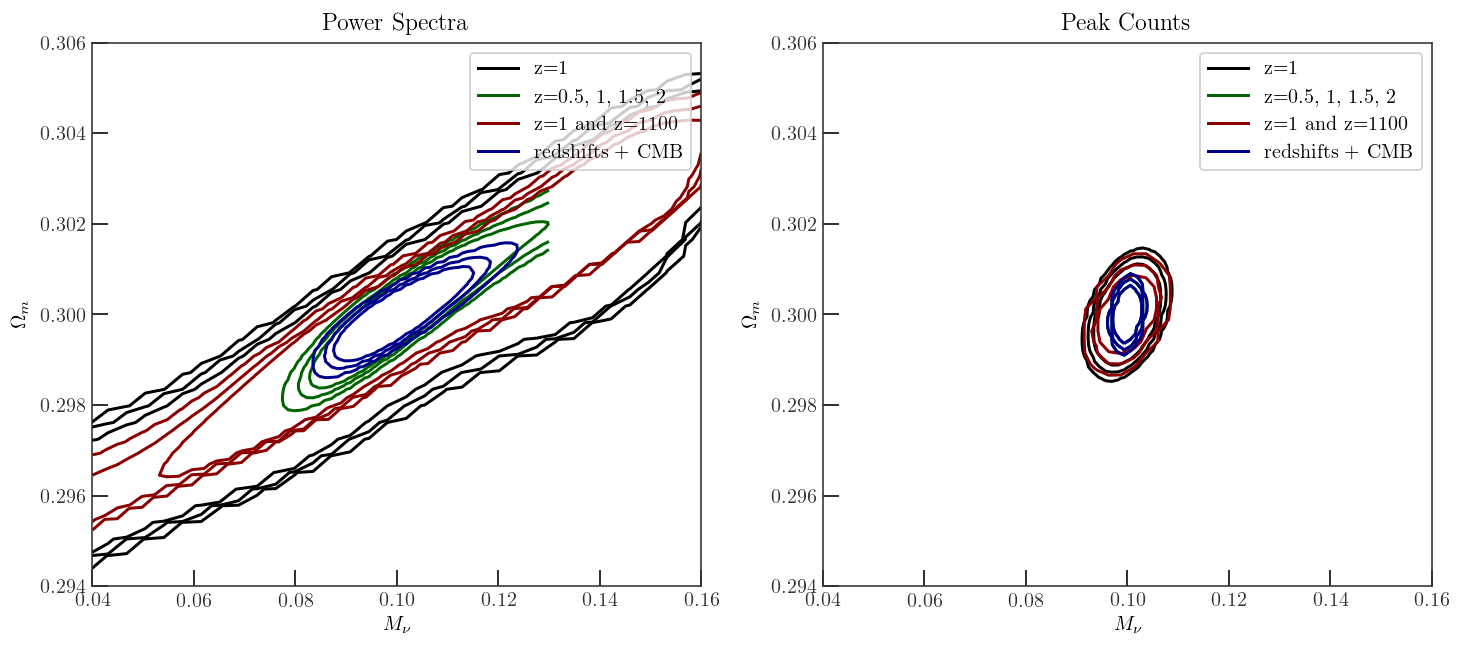

In [16]:
ax[0].set_xlim(0.04, 0.16)
ax[1].set_xlim(0.04, 0.16)
ax[0].set_ylim(0.294,0.306)
ax[1].set_ylim(0.294,0.306)
fig

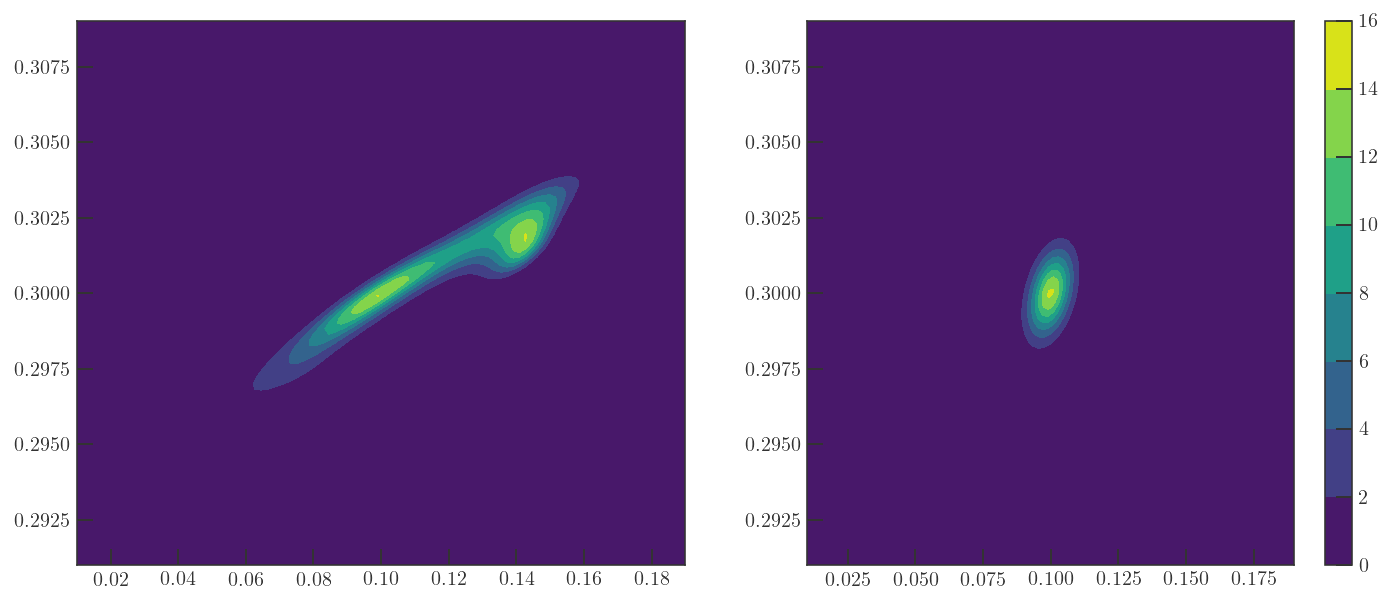

In [60]:
nres = 100
u = np.linspace(0.1 - 0.03*3, 0.1 + 0.03*3, nres)
v = np.linspace(0.3 - 0.003*3, 0.3 + 0.003*3, nres)
w = np.linspace(2.1 - 0.01*3, 2.1 + 0.01*3, nres)
U, V = np.meshgrid(u, v)

PS_flat = np.sum(PS_cube1,axis=2) 
PC_flat = np.sum(PC_cube1,axis=2)

# PS_flat /= np.sum(np.sum(PS_flat, axis=0), axis=0)
# PC_flat /= np.sum(np.sum(PC_flat, axis=0), axis=0)

fig, ax = plt.subplots(1,2,figsize=(12,5))
CS = ax[0].contourf( U, V, PS_flat )
cbar = plt.colorbar(CS)
CS = ax[1].contourf( U, V, PC_flat )

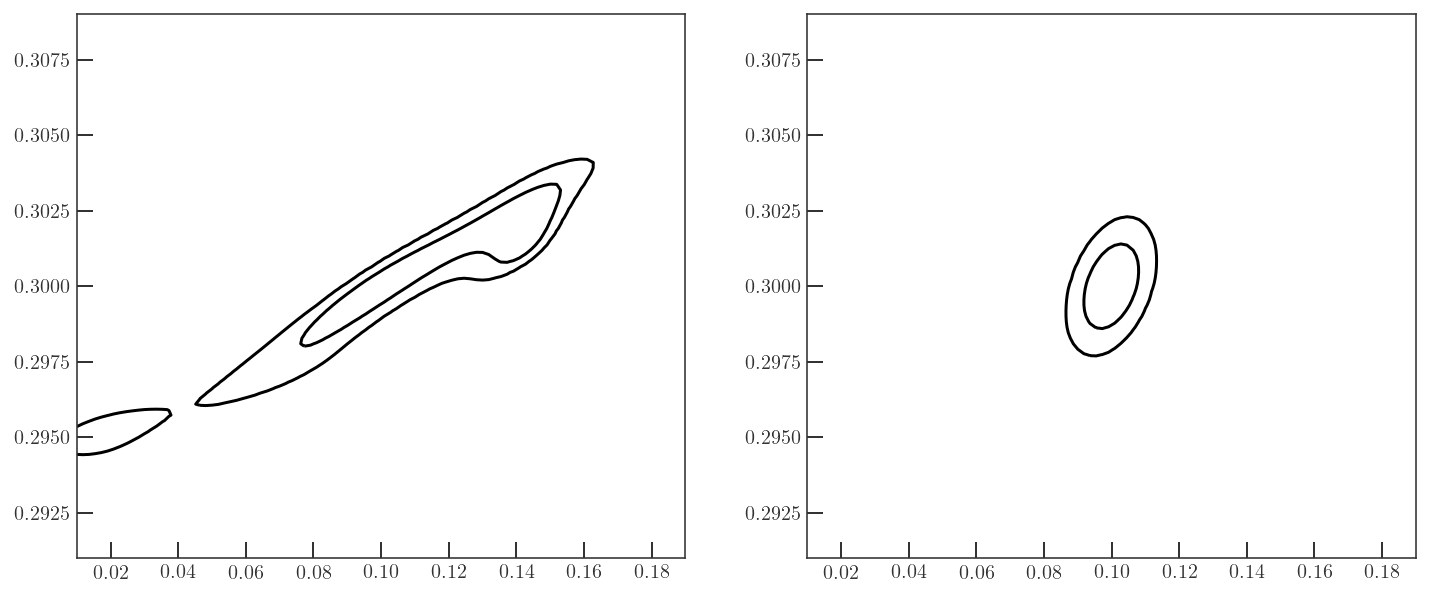

In [63]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

c_68, c_95, c_99 = findlevel(PS_flat)
ax[0].contour( U, V, PS_flat, levels=[c_95, c_68], \
                     colors=('black'))
ax[0].plot([],[], '-', label='z=1', color='black')

c_68, c_95, c_99 = findlevel(PC_flat)
ax[1].contour( U, V, PC_flat, levels=[c_95, c_68], \
                     colors=('black'))
ax[1].plot([],[], '-', label='z=1', color='black')

In [37]:
c_68, c_95, c_99

(0.003633243548573817, 0.0004939010145395093, 3.59791133184892e-05)

In [55]:
np.sum(PS_flat.flatten())

0.99999999999999978

In [58]:
import scipy
PS_flat / scipy.sum(PS_flat)

array([[  1.61007680e-31,   2.42925017e-34,   2.60282335e-37, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  6.67472913e-28,   1.70615558e-30,   3.07148635e-33, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.45195642e-24,   6.27359117e-27,   1.89373850e-29, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          6.59201711e-43,   1.74145536e-41,   1.56731919e-39],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          7.84832030e-47,   1.42306472e-45,   9.69333695e-44],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          5.57798033e-51,   9.76632002e-50,   3.98761214e-48]])

In [64]:
U.shape

(100, 100)